**Credit Card Default dataset**

In [1]:
import os
import tarfile
import urllib
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import plotly.express as px
#pandas setting
pd.set_option('display.max_columns', 500)

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

In [5]:
housing.head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [7]:
housing.shape


(20640, 10)

In [8]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [9]:
housing.columns.values


array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'], dtype=object)

In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
housing["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [12]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

**Split the data**

In [22]:
# How to create new variable for income as categories
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [23]:
# to make this code output identical at every run
np.random.seed(42)
# For illustration only we can use develop in numpy. Sklearn has train_test_split()

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set_permutation, test_set_permutation = split_train_test(housing, 0.2)

In [24]:
train_set_permutation.shape

(16512, 11)

In [25]:
test_set_permutation.shape

(4128, 11)

In [26]:
#or you can use the train test split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head(1)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   

      ocean_proximity income_cat  
20046          INLAND          2

In [27]:
#or you can use the stratified shuffle split
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [28]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_train_set), #created on stratified split
    "Random": income_cat_proportions(train_set), #created on train test split
    "Custom": income_cat_proportions(train_set_permutation), #created on custom function
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props["Custom. %error"] = 100 * compare_props["Custom"] / compare_props["Overall"] - 100

compare_props

Overall  Stratified    Random    Custom  Rand. %error  Strat. %error  \
1  0.039826    0.039789  0.039729  0.039729     -0.243309      -0.091241   
2  0.318847    0.318859  0.317466  0.317466     -0.433065       0.003799   
3  0.350581    0.350594  0.348595  0.348595     -0.566611       0.003455   
4  0.176308    0.176296  0.178537  0.178537      1.264084      -0.006870   
5  0.114438    0.114462  0.115673  0.115673      1.079594       0.021169   

   Custom. %error  
1       -0.243309  
2       -0.433065  
3       -0.566611  
4        1.264084  
5        1.079594

**Now lets start visualizing the data**

**Histograms**

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

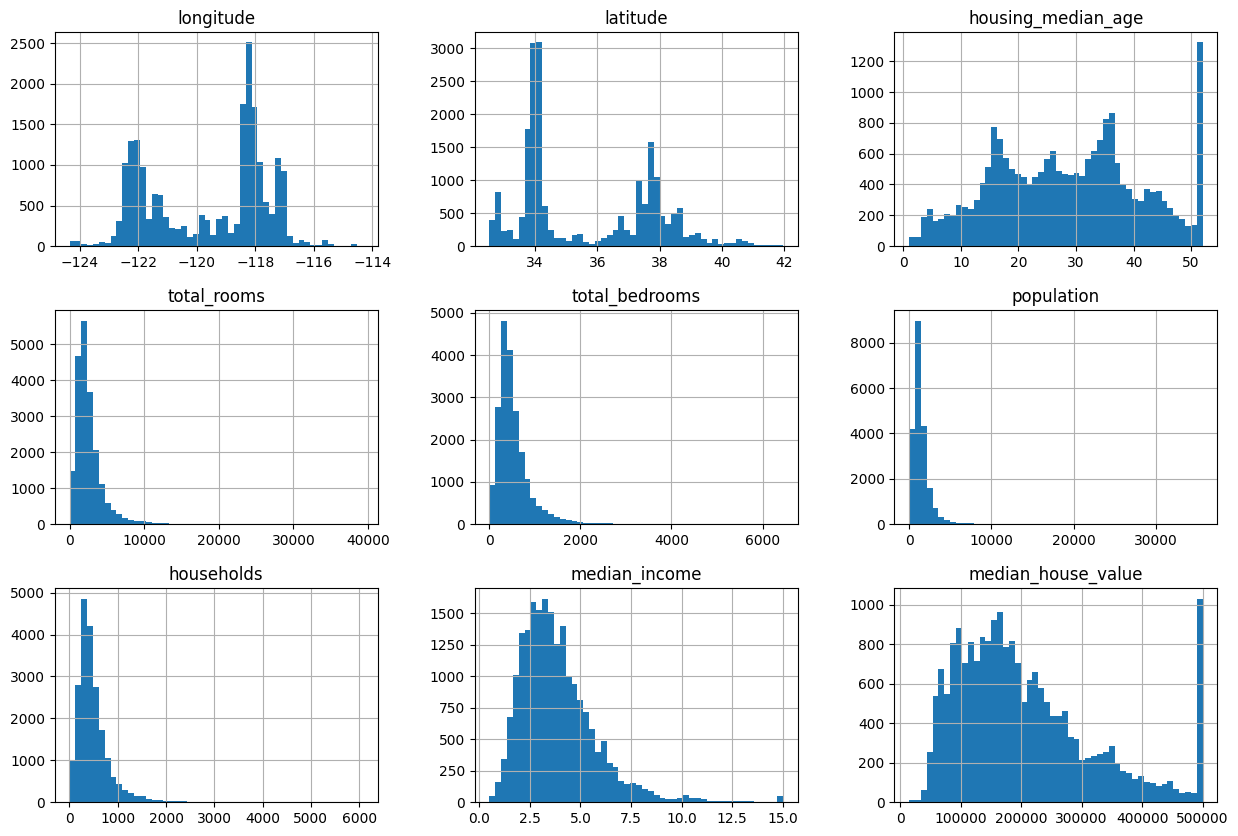

In [39]:
#using pandas
housing.hist(bins=50, figsize=(15,10))

(array([ 719., 1104., 2235., 2681., 2510., 2354., 3555., 1900., 1616.,
        1966.]),
 array([ 1. ,  6.1, 11.2, 16.3, 21.4, 26.5, 31.6, 36.7, 41.8, 46.9, 52. ]),
 <BarContainer object of 10 artists>)

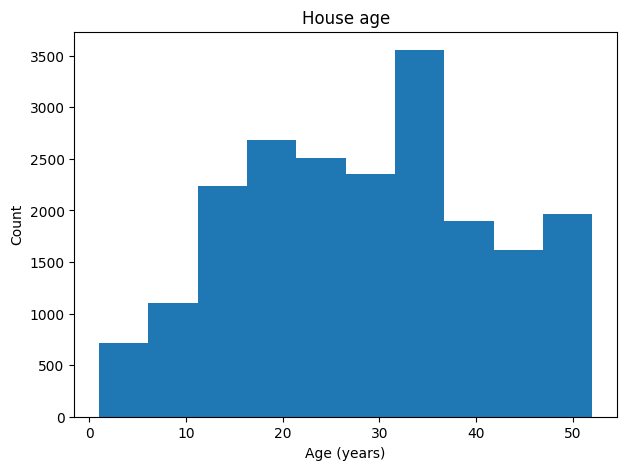

In [40]:
#matplotlib
housing_con = housing.drop(['ocean_proximity'],axis=1)
plt.figure(figsize=(7,5))
plt.title("House age")
plt.ylabel("Count")
plt.xlabel("Age (years)")
plt.hist(housing_con['housing_median_age'])

Text(0.5, 1.0, 'Seaborn Histogram Chart')

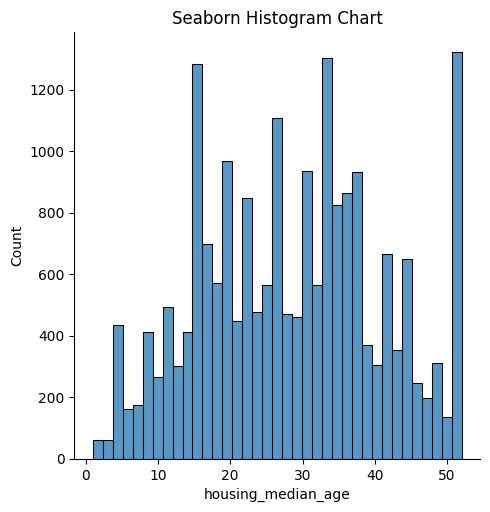

In [41]:
#with seaborn
sns.displot(data=housing, x="housing_median_age")
plt.title("Seaborn Histogram Chart")

In [74]:
#with plotly
fig = px.histogram(housing, x="housing_median_age",title="Plotly Histogram Plot",width=900, height=500)
fig.show()

**Pairplots using Seaborn or Plotly**

CPU times: user 35.3 s, sys: 502 ms, total: 35.8 s
Wall time: 35.9 s


Text(0.5, 1.0, 'Pairplot')

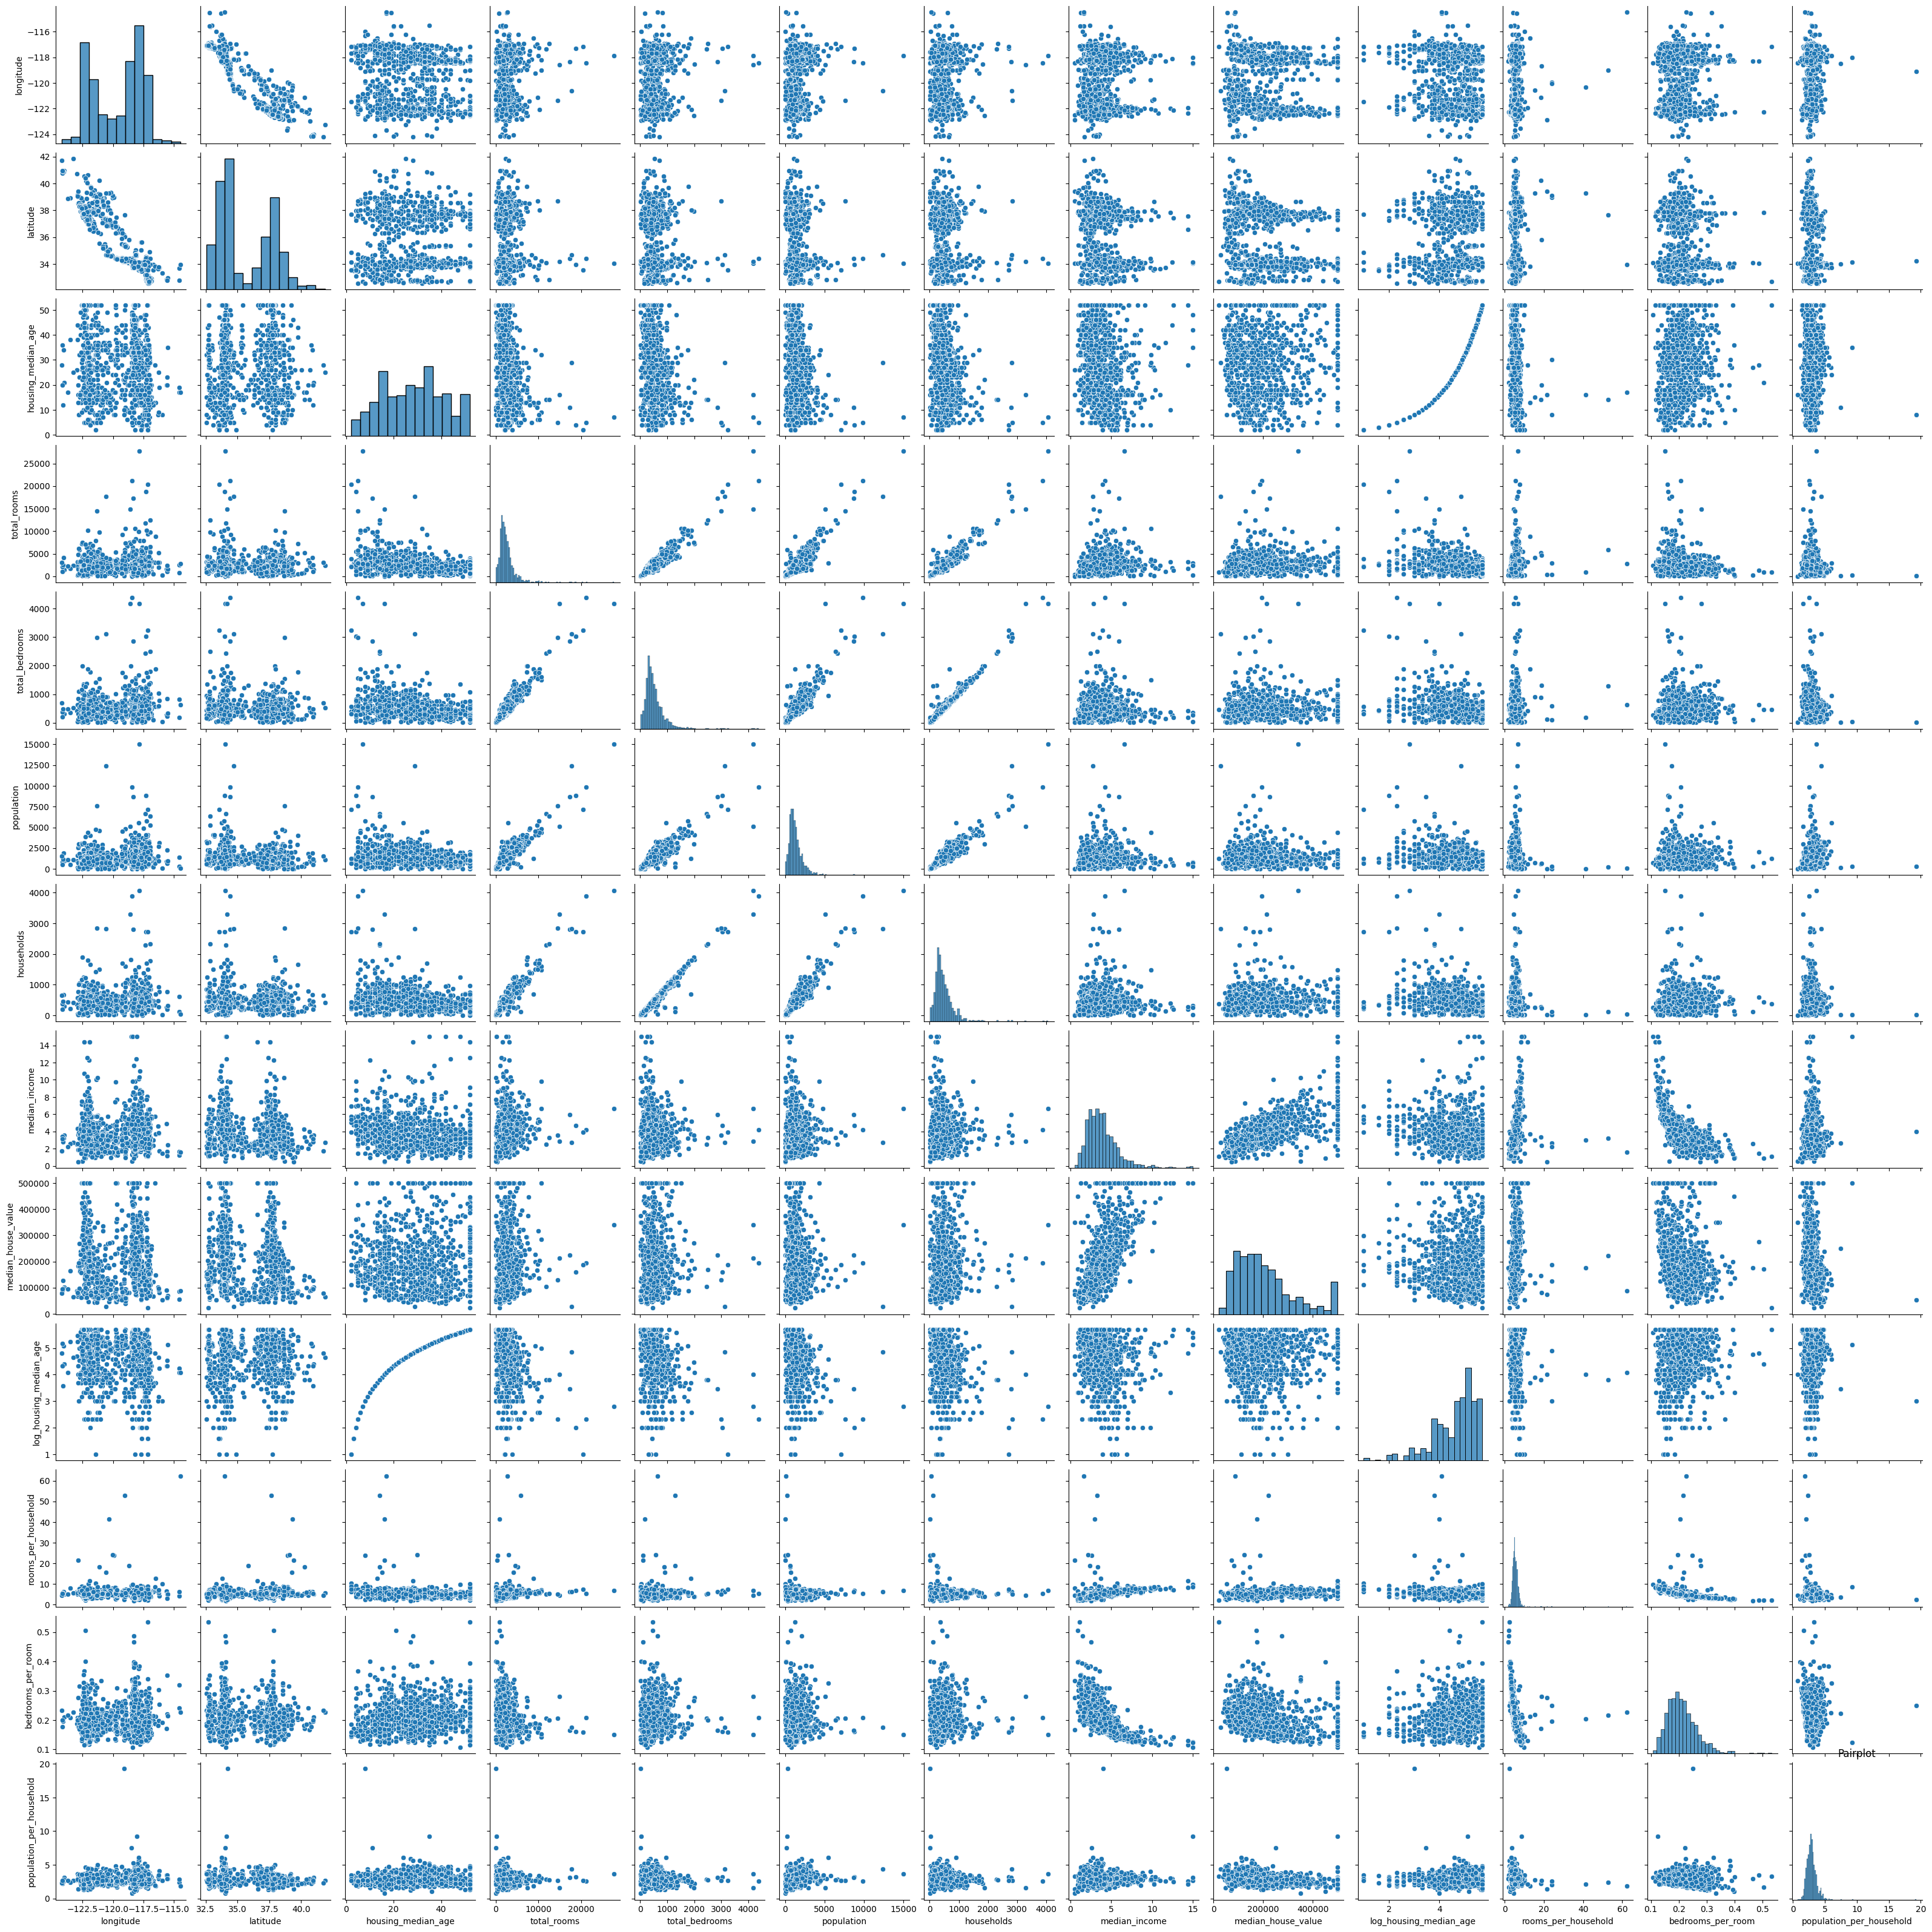

In [76]:
#seaborn
%%time
g = sns.pairplot(housing.sample(1000))
plt.title('Pairplot')

In [78]:
#pairplot using plotly.
dfd = housing.sample(1000)
fig = go.Figure(data=go.Splom(
                  dimensions=[dict(label='longitude', values=dfd['longitude']),
                              dict(label='latitude', values=dfd['latitude']),
                              dict(label='housing_median_age', values=dfd['housing_median_age']),
                              dict(label='total_rooms', values=dfd['total_rooms']),
                              dict(label='total_bedrooms', values=dfd['total_bedrooms']),
                              dict(label='population', values=dfd['population']),
                              dict(label='households', values=dfd['households']),
                              dict(label='median_income', values=dfd['median_income'])],
                  marker=dict(color=dfd['median_house_value'],
                              size=5,
                              colorscale='Bluered',
                              line=dict(width=0.5,
                                        color='rgb(230,230,230)')),
                  diagonal=dict(visible=False)))

title = "Scatterplot Matrix (SPLOM) for Housing Data"
fig.update_layout(title=title,
                  dragmode='select',
                  width=1200,
                  height=1200,
                  hovermode='closest')

fig.show()

**Bar chart on entire data**

Text(0.5, 1.0, 'Matplotlib Bar Chart')

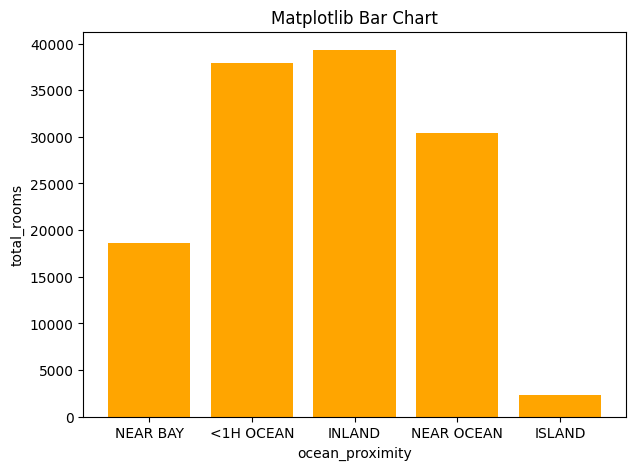

In [43]:
#using matplotlib
plt.figure(figsize=(7,5))
plt.bar(housing["ocean_proximity"], housing["total_rooms"], color="orange");
plt.xlabel('ocean_proximity'); plt.ylabel('total_rooms');
plt.title("Matplotlib Bar Chart")

Text(0.5, 1.0, 'Seaborn Bar Chart')

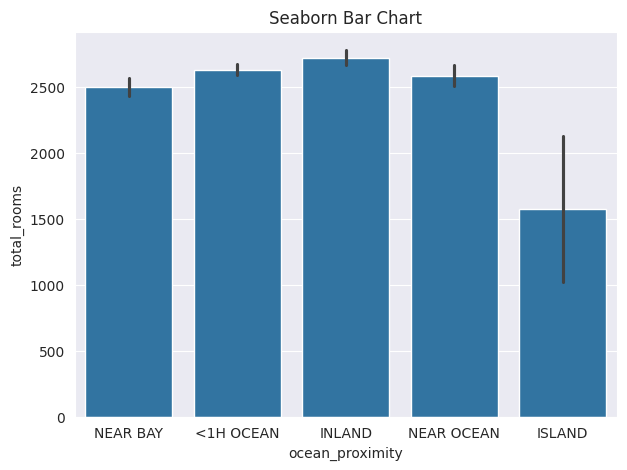

In [44]:
#using seaborn
import seaborn as sns
with sns.axes_style("darkgrid"):
  fig, ax = plt.subplots(figsize=(7,5))
  g = sns.barplot(
      data=housing,
      x="ocean_proximity", y="total_rooms",
      ax=ax,
      )
ax.set_title("Seaborn Bar Chart")

**Scattered Plot on entire data**

Text(0.5, 1.0, 'Matplotlib Scattered Chart')

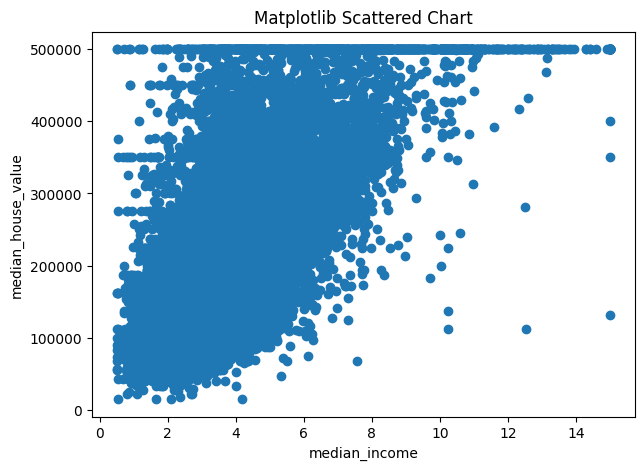

In [45]:
#using matplotlib
plt.figure(figsize=(7,5))
plt.scatter(housing["median_income"],housing["median_house_value"])
plt.xlabel("median_income")
plt.ylabel("median_house_value")
plt.title("Matplotlib Scattered Chart")

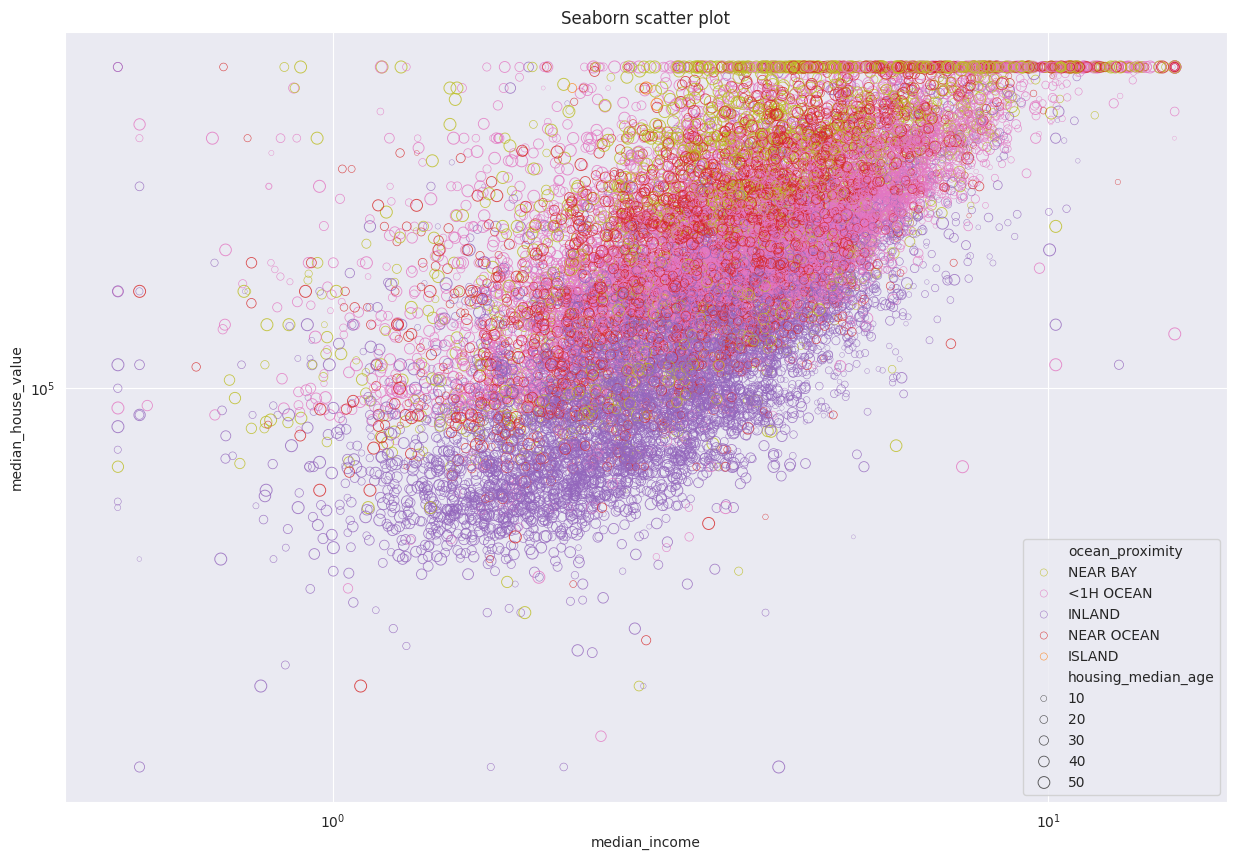

In [46]:
#using seaborn
import seaborn as sns
with sns.axes_style("darkgrid"):
  fig, ax = plt.subplots(figsize=(15, 10))
  g = sns.scatterplot(
      data=housing,
      x="median_income", y="median_house_value",
      hue="ocean_proximity", size="housing_median_age",
      sizes=(10, 100), linewidth=0, marker=r'$\bigcirc$', alpha=0.8, palette="tab10_r",
      ax=ax,
      )
  ax.set(xscale="log", yscale="log")
  ax.set_title("Seaborn scatter plot")

In [47]:
#using Plotly
import plotly.express as px

fig = px.scatter(housing, x="median_income", y="median_house_value", color="ocean_proximity",
                 hover_data=['ocean_proximity'],title="Plotly Scattered Plot",width=1200, height=500)

fig.update_traces(marker=dict(line=dict(width=2)),
                  selector=dict(mode='markers'))

fig.show()

In [48]:
#another plotly scattered plot
housing['log_housing_median_age'] = np.log2(housing['housing_median_age'])

fig = px.scatter(housing, x="population", y="households", color="ocean_proximity",
                 size='log_housing_median_age', hover_data=['ocean_proximity'],log_x=True,log_y=True,title="Plotly Scattered Plot",width=1200, height=500)

fig.update_traces(marker=dict(line=dict(width=2)),
                  selector=dict(mode='markers'))

fig.show()

Converting Continous values to categories and plot histogram

<Axes: >

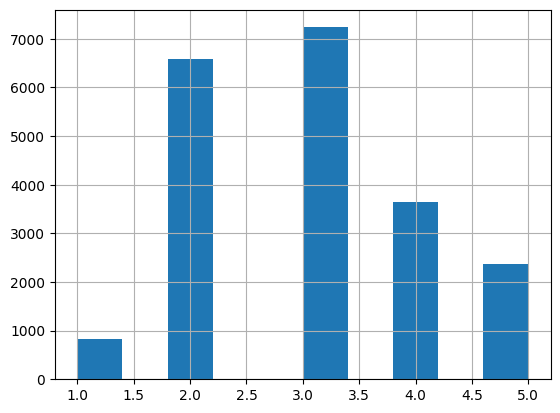

In [49]:
# How to create new variable for income as categories
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts()
housing["income_cat"].hist()

**Scattered Plot on Longtitude and Latitude , including Map**

Text(0.5, 1.0, 'California Map')

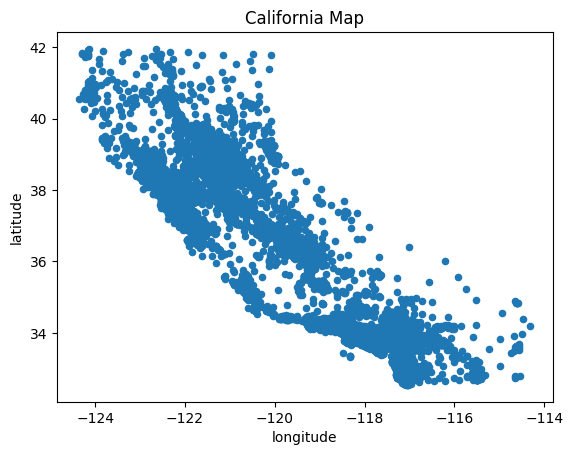

In [50]:
#pandas
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.title('California Map')

Text(0.5, 1.0, 'California Map')

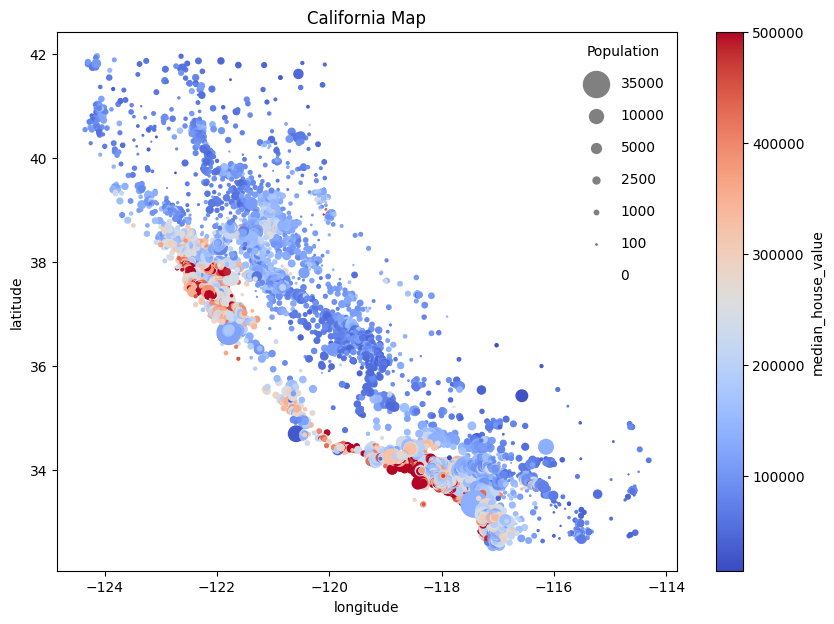

In [51]:
# a better scattered plot
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=1,
    s=housing["population"]/100, figsize=(10,7), #label="population",
    c="median_house_value", cmap="coolwarm", colorbar=True,
    sharex=False)
for area in [35000,10000,5000,2500,1000,100,0]:
    plt.scatter([], [], c="gray", alpha=1, s=area/100, label=str(area))
plt.legend(scatterpoints=1, frameon=False, labelspacing=1.3, title="Population");
plt.title('California Map')

In [52]:
#another simple way using plotly
import plotly.express as px
fig = px.scatter_mapbox(housing, lat='latitude', lon='longitude', color = 'median_house_value',
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=4.5,
                  mapbox_style="carto-positron")
fig.show()

**Correlation Plot using heatmap**

In [53]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

<ipython-input-53-51a0e6bf2eb4>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



median_house_value        1.000000
median_income             0.688075
total_rooms               0.134153
housing_median_age        0.105623
log_housing_median_age    0.076467
households                0.065843
total_bedrooms            0.049686
population               -0.024650
longitude                -0.045967
latitude                 -0.144160
Name: median_house_value, dtype: float64

<ipython-input-54-128e9184beff>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



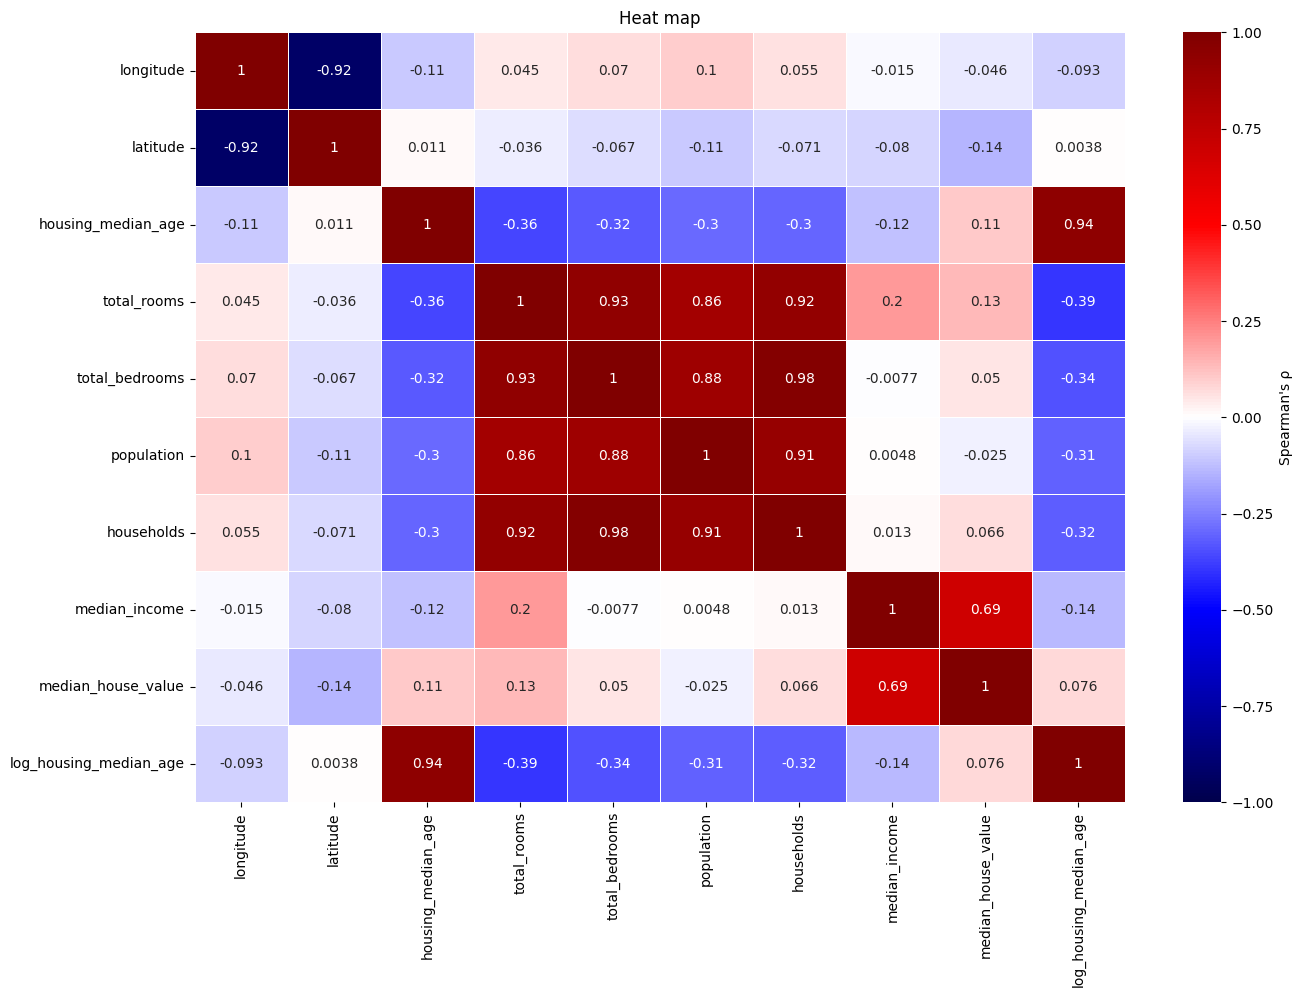

In [54]:
plt.figure(figsize=(15,10))
df_cm = housing.corr(method="pearson")
ax = sns.heatmap(df_cm, cmap="seismic", annot=True, linewidths=.5, cbar_kws={"label": "Spearman's ρ"}, vmin=-1, vmax=1);
ax.set_title("Heat map");

In [55]:
#feature engineering
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value        1.000000
median_income             0.688075
total_rooms               0.134153
housing_median_age        0.105623
log_housing_median_age    0.076467
households                0.065843
total_bedrooms            0.049686
population               -0.024650
longitude                -0.045967
latitude                 -0.144160
Name: median_house_value, dtype: float64

**Box Plot Visualization**

Text(0.5, 1.0, 'Box Plot Visual in Seaborn')

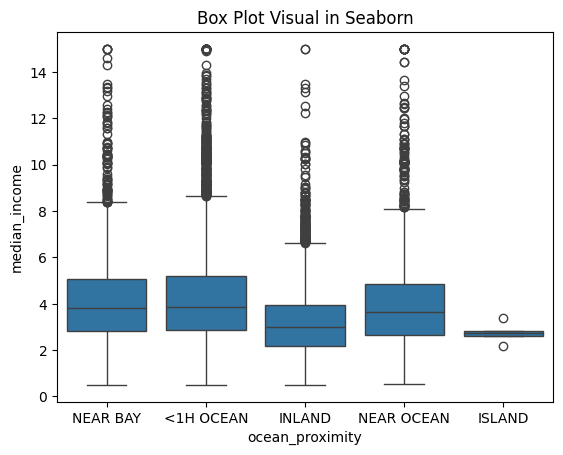

In [57]:
sns.boxplot(x= "ocean_proximity",y = "median_income", data = housing)
plt.title('Box Plot Visual in Seaborn')

In [58]:
#box Plot in Plotly
fig = px.box(housing, x= "ocean_proximity",y = "median_income", title = "Box Plot Plotly")
fig.show()

**Violin Plot**

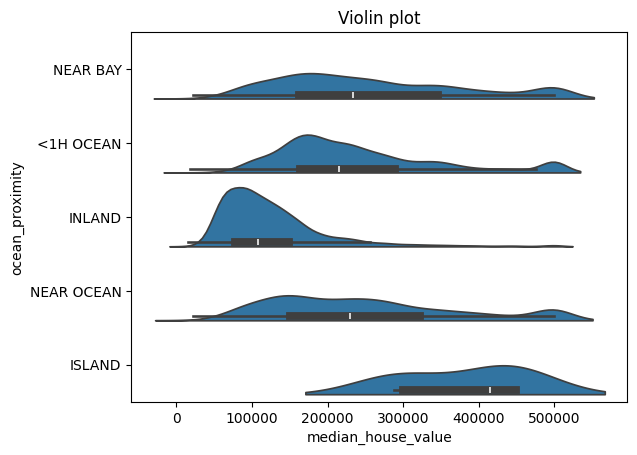

In [59]:
g = sns.violinplot(x="median_house_value", y="ocean_proximity", data=housing,
                   split=True,
                   )
g.set_title("Violin plot");

In [60]:
import plotly.graph_objects as go
df = housing
fig = go.Figure()

fig.add_trace(go.Violin(y=df["median_house_value"], x=df['ocean_proximity'],
                        legendgroup='Old', scalegroup='Old', name='Old',
                        side='negative',
                        line_color='blue'))
fig.add_trace(go.Violin(y=df["median_house_value"], x=df['ocean_proximity'],
                        legendgroup='New', scalegroup='New', name='New',
                        side='positive',
                        line_color='orange')
)
fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0, violinmode='overlay')
fig.show()

**Data Preprocessing / Feature Engineering**

In [61]:
#Examin new features
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value        1.000000
median_income             0.688075
total_rooms               0.134153
housing_median_age        0.105623
log_housing_median_age    0.076467
households                0.065843
total_bedrooms            0.049686
population               -0.024650
longitude                -0.045967
latitude                 -0.144160
Name: median_house_value, dtype: float64

In [62]:
### Custom transformers
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [63]:
print(housing.values)
print(type(housing))

[[-122.23 37.88 41.0 ... 6.984126984126984 0.14659090909090908
  2.5555555555555554]
 [-122.22 37.86 21.0 ... 6.238137082601054 0.15579659106916466
  2.109841827768014]
 [-122.24 37.85 52.0 ... 8.288135593220339 0.12951601908657123
  2.8022598870056497]
 ...
 [-121.22 39.43 17.0 ... 5.20554272517321 0.21517302573203195
  2.325635103926097]
 [-121.32 39.43 18.0 ... 5.329512893982808 0.21989247311827956
  2.1232091690544412]
 [-121.24 39.37 16.0 ... 5.254716981132075 0.22118491921005387
  2.616981132075472]]
<class 'pandas.core.frame.DataFrame'>


Data Preprocessing using Sklearn Pipeline

In [64]:
housing_num_train = train_set.drop(['ocean_proximity','median_house_value'], axis = 1)
housing_train_columns = housing_num_train.columns
# you can either use train or test to get column names

In [66]:
from sklearn.impute import SimpleImputer    #import
imputer = SimpleImputer(strategy="median")  # define the object and set the strategy
imputer.strategy

'median'

In [68]:
# Pipelines

#################
# build a pipeline for preprocessing the numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('One_Hot', OneHotEncoder(drop='first')),
    ])

#full transformation Column Transformer
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_train_columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

train_final = full_pipeline.fit_transform(train_set)
test_final = full_pipeline.transform(test_set)

train_final

array([[ 1.27258656, -1.3728112 ,  0.34849025, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.70916212, -0.87669601,  1.61811813, ...,  0.        ,
         0.        ,  1.        ],
       [-0.44760309, -0.46014647, -1.95271028, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.59946887, -0.75500738,  0.58654547, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41489815,  0.99543676,  1.85617335, ...,  0.        ,
         1.        ,  0.        ]])

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Create a class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(housing_train_columns)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(['ocean_proximity'])),
        ('onehot', OneHotEncoder(drop='first')),

    ])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),

    ])

In [70]:
train_final = full_pipeline.fit_transform(train_set)
test_final = full_pipeline.transform(test_set)

train_final

<16512x16 sparse matrix of type '<class 'numpy.float64'>'
	with 207315 stored elements in Compressed Sparse Row format>